In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version =1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [3]:
X, y = mnist['data'], mnist['target']
X.shape, y.shape

((70000, 784), (70000,))

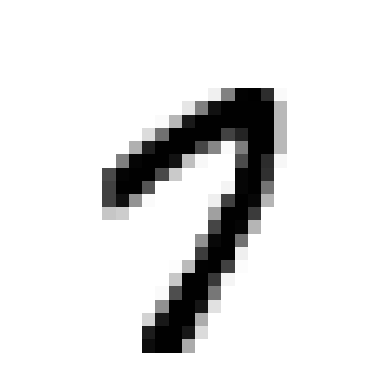

In [4]:
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X.iloc[8699]
some_digit_image = some_digit.values.reshape(28, 28)

plt.imshow(some_digit_image, cmap='binary')
plt.axis('off')
plt.show()

In [5]:
y[8699]

'7'

In [6]:
import numpy as np
y = y.astype(np.uint8)

In [7]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [8]:
y_train_7 = (y_train == 7)
y_test_7 = (y_test == 7)


In [9]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state = 42)
sgd_clf.fit(X_train, y_train_7)


,loss,'hinge'
,penalty,'l2'
,alpha,0.0001
,l1_ratio,0.15
,fit_intercept,True
,max_iter,1000
,tol,0.001
,shuffle,True
,verbose,0
,epsilon,0.1
,n_jobs,None


In [10]:
sgd_clf.predict([some_digit])

array([ True])

In [11]:
# Implementing Cross-Validation
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits = 3)

for train_index, test_index in skfolds.split(X_train, y_train_7):
  clone_clf = clone(sgd_clf)
  X_train_folds = X_train.iloc[train_index]
  y_train_folds = y_train_7.iloc[train_index]
  X_test_fold = X_train.iloc[test_index]
  y_test_fold = y_train_7.iloc[test_index]

  clone_clf.fit(X_train_folds, y_train_folds)
  y_pred = clone_clf.predict(X_test_fold)
  n_correct = sum(y_pred == y_test_fold)
  print(n_correct / len(y_pred))

0.98105
0.9735
0.95335


In [12]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_7, cv=3, scoring='accuracy')


array([0.98105, 0.9735 , 0.95335])

In [13]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
  def fit(self,X, y=None):
    return self
  def predict(self, X):
    return np.zeros((len(X),1), dtype = bool)

In [14]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_7, cv=3, scoring='accuracy')

array([0.89535, 0.8984 , 0.893  ])

In [15]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_7, cv = 3)

In [16]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_7, y_train_pred)

array([[52581,  1154],
       [  688,  5577]])

In [17]:
from sklearn.metrics import precision_score, recall_score
precision_score(y_train_7, y_train_pred)


0.8285544495617293

In [18]:
recall_score(y_train_7, y_train_pred)

0.8901835594573024

In [19]:
from sklearn.metrics import f1_score
f1_score(y_train_7, y_train_pred)

0.858264081255771

In [20]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([4373.97250597])

In [21]:
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
print(y_some_digit_pred)

[False]


In [22]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_7, cv=3, method='decision_function')

In [23]:
y_scores

array([-26444.17375986, -29232.36194438, -24011.8285088 , ...,
       -24767.21328011, -18076.58386084, -12330.55080778], shape=(60000,))

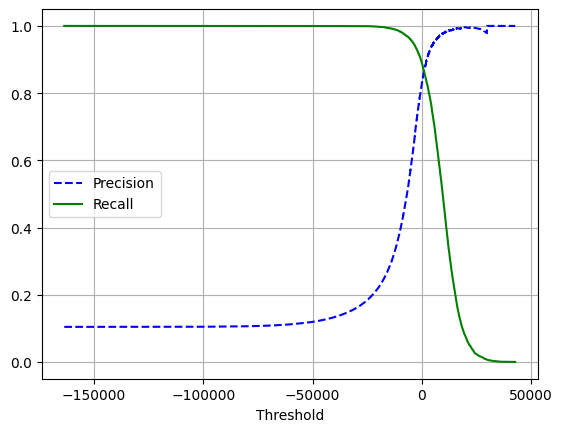

In [24]:
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_7, y_scores)

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
  plt.plot(thresholds, precisions[:-1], 'b--', label="Precision")
  plt.plot(thresholds, recalls[:-1], 'g-', label="Recall")
  plt.legend()
  plt.xlabel("Threshold")
  plt.grid(True)

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

In [25]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]
print(threshold_90_precision)

2288.724768166237


In [26]:
y_train_pred_90 = (y_scores>= threshold_90_precision)

In [27]:
precision_score(y_train_7, y_train_pred_90)

0.9000864304235091

In [28]:
recall_score(y_train_7, y_train_pred_90)

0.8311252992817239

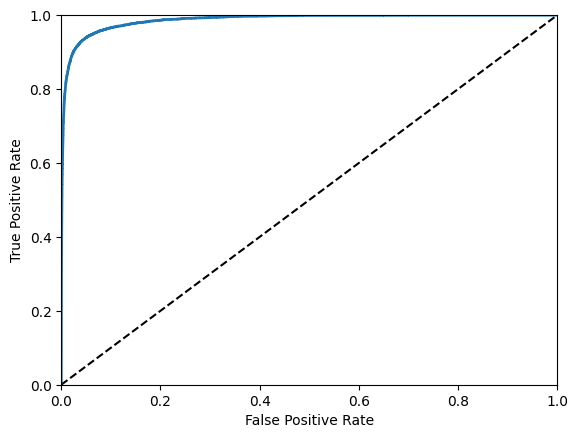

In [29]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train_7, y_scores)

def plot_roc_curve(fpr, tpr, label=None):
  plt.plot(fpr, tpr, linewidth=2, label=label)
  plt.plot([0,1], [0,1], 'k--')
  plt.axis([0,1,0,1])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
plot_roc_curve(fpr, tpr)
plt.show()

In [30]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_7, y_scores)

0.986670497551944

In [31]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_7, cv=3, method='predict_proba')

In [32]:
y_scores_forest = y_probas_forest[:,1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_7, y_scores_forest)

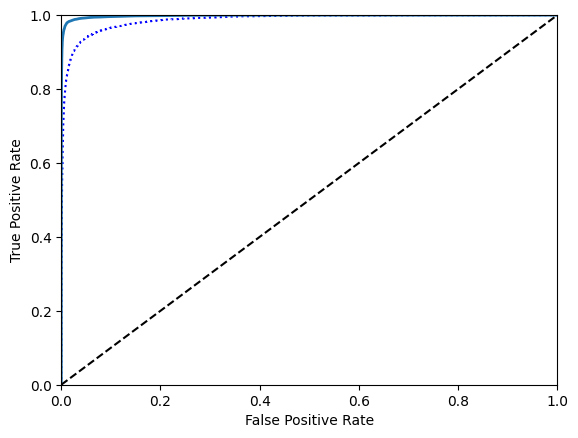

In [33]:
plt.plot(fpr, tpr, 'b:', label='SGD')
plot_roc_curve(fpr_forest, tpr_forest, 'Random Forest')
plt.show()

In [34]:
roc_auc_score(y_train_7, y_scores_forest)

0.9982747530426836

In [35]:
from sklearn.svm import SVC
svm_clf = SVC()
svm_clf.fit(X_train, y_train)
svm_clf.predict([some_digit])

array([7], dtype=uint8)

In [36]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores

array([[ 5.13165937,  0.70101876,  1.71822337,  5.09094363,  7.0675701 ,
         5.01783386, -0.31382413,  9.31357427,  2.75406342,  8.31356277]])

In [37]:
np.argmax(some_digit_scores)

np.int64(7)

In [38]:
svm_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [39]:
svm_clf.classes_[7]

np.uint8(7)

In [40]:
from sklearn.multiclass import OneVsRestClassifier
ovr_clf = OneVsRestClassifier(SVC())
ovr_clf.fit(X_train, y_train)
ovr_clf.predict([some_digit])

array([7], dtype=uint8)

In [41]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([7], dtype=uint8)

In [42]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([7], dtype=uint8)

In [43]:
sgd_clf.decision_function([some_digit])

array([[-16301.71110019, -40791.69277892, -23019.02439913,
         -5445.41839327, -13803.84277833,  -5375.28764969,
        -36501.31589949,   4896.90918096,  -4539.62126771,
          1697.70682169]])

In [44]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring = 'accuracy')

array([0.87365, 0.85835, 0.8689 ])

In [45]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring = 'accuracy')

array([0.8983, 0.891 , 0.9018])

In [46]:
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train, cv=3)
conf_mx = confusion_matrix(y_train,y_train_pred)
conf_mx

array([[5635,    0,   61,   10,   16,   50,   46,    7,   66,   32],
       [   3, 6393,   95,   21,   16,   47,   15,   27,  109,   16],
       [  72,   56, 5174,   89,   69,   39,  163,   66,  212,   18],
       [  58,   32,  217, 4941,   23,  441,   32,   56,  216,  115],
       [  11,   26,   46,    6, 5298,   26,   73,   32,   87,  237],
       [  68,   23,   58,  150,   83, 4606,  174,   26,  152,   81],
       [  40,   13,   56,    6,   22,  113, 5625,    5,   36,    2],
       [  23,   24,  103,   36,  124,   40,   10, 5228,   75,  602],
       [  40,  101,  158,  122,   49,  457,   77,   35, 4666,  146],
       [  33,   18,   66,   83,  515,  127,    4,  485,  166, 4452]])

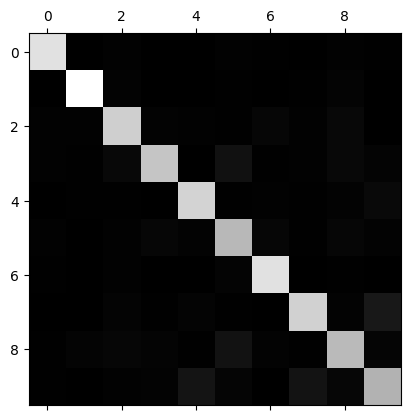

In [47]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

In [48]:
row_sums = conf_mx.sum(axis=1, keepdims = True)
norm_conf_mx = conf_mx/ row_sums

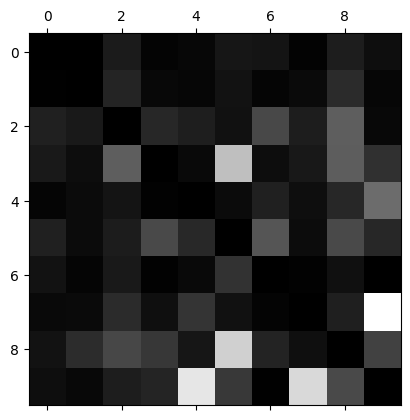

In [49]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap = plt.cm.gray)
plt.show()

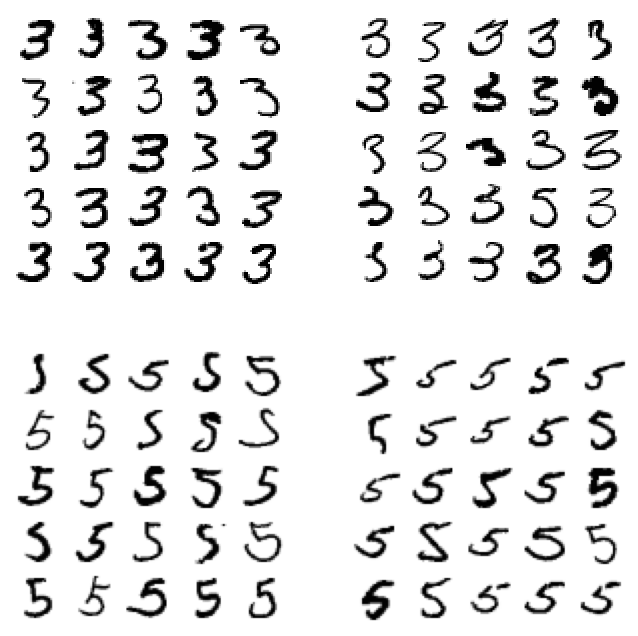

In [50]:
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    # Convert DataFrame rows to numpy arrays
    images = [instances.iloc[i].values.reshape(size, size) for i in range(len(instances))]

    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    # Append empty images to fill the last row if necessary
    if n_empty > 0:
        # Create a single zero image of correct size for empty slots
        images.extend([np.zeros((size, size))] * n_empty)

    for row in range(n_rows):
        r_images = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(r_images, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap=mpl.cm.binary, **options)
    plt.axis("off")

cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]
plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.show()

In [51]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >=7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

,n_neighbors,5
,weights,'uniform'
,algorithm,'auto'
,leaf_size,30
,p,2
,metric,'minkowski'
,metric_params,None
,n_jobs,None


In [52]:
knn_clf.predict([some_digit])

array([[ True,  True]])

In [53]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average = 'macro')

0.9764102655606048

In [54]:
noise = np.random.randint(0,100,(len(X_train),784))
X_train_mod = X_train + noise
noise = np.random.randint(0,100,(len(X_test),784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

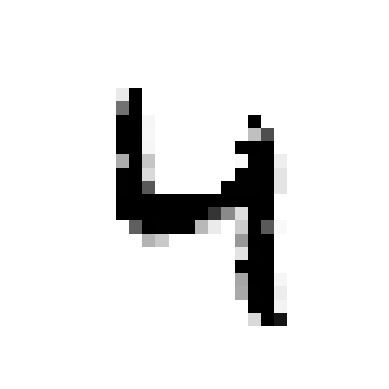

In [55]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np

some_index = 784 # Define 'some_index' to select a digit from the test set

def plot_digit(digit_array):
    # Reshape the digit array (which will be a 2D array like (1, 784) from predict)
    # and plot the first (and only) image.
    image = digit_array[0].reshape(28, 28)
    plt.imshow(image, cmap=mpl.cm.binary)
    plt.axis("off")
    plt.show()

knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod.iloc[some_index]]) # Access row correctly using .iloc
plot_digit(clean_digit)